# Exploratory Data Analysis

In [13]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Two potential options include: '9M96E2' and '48N6ES'.
missile = '9M96E2'
folder_path = f'../data/{missile}'

In [20]:
# list comprehension to build a list of dataframes
# Remove the values with max_range = -1
for f in os.listdir(folder_path + '/raw'):
    if f.endswith('.csv'):
        df = pd.read_csv(os.path.join(folder_path + '/raw', f), header=None, sep=';', names=['sht_alt_ft','sht_spd_kt', 'tgt_alt_ft', 'tgt_spd_kt', 'tgt_head_deg', 'tgt_rel_head_deg', 'max_range'])
        df = df[df['max_range'] != -1]
        df.drop(['sht_alt_ft','sht_spd_kt','tgt_rel_head_deg'], axis=1, inplace=True)
        df.to_csv(os.path.join(folder_path, f), index=False)

dfs = [pd.read_csv(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith('.csv')]

# concatenate them together
df_0_180 = pd.concat(dfs).reset_index(drop=True)
df_0_180.to_csv(os.path.join(folder_path, 'wez_exp_out_0_180.csv'), index=False)

### Descriptive Statistics

In [21]:
df_0_180

,tgt_alt_ft,tgt_spd_kt,tgt_head_deg,max_range
0,31028.350189,809.229039,163.174801,22.265625
1,19722.491907,349.177436,170.565087,22.578125
2,24106.093924,745.832481,167.281644,52.890625
3,18945.895824,750.339315,169.380513,53.984375
4,43491.099137,760.142035,170.147129,21.640625
...,...,...,...,...
24775,1289.559106,803.955570,149.274622,10.234375
24776,24754.679367,304.804265,152.857542,16.015625
24777,803.363070,691.984525,150.840015,12.109375
24778,-2986.909157,451.893418,151.041145,17.890625


### Histograms and Boxplot

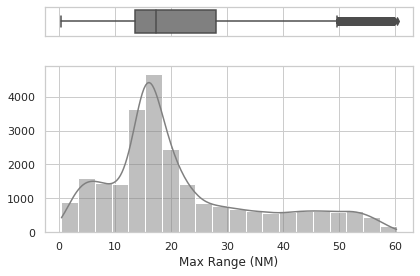

In [22]:
sns.set(style="whitegrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(x=df_0_180["max_range"], ax=ax_box, color='gray')
sns.histplot(data=df_0_180, x="max_range", ax=ax_hist, kde=True, color='gray', bins=20)
plt.xlabel('Max Range (NM)')
plt.ylabel('')
sns.color_palette("flare", as_cmap=True)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

plt.show()
#plt.savefig ('figures/histbox_eps.eps', format ='eps')
# plt.savefig ('figures/histbox_400dpi.png', format ='png', dpi=400)

### Correlation

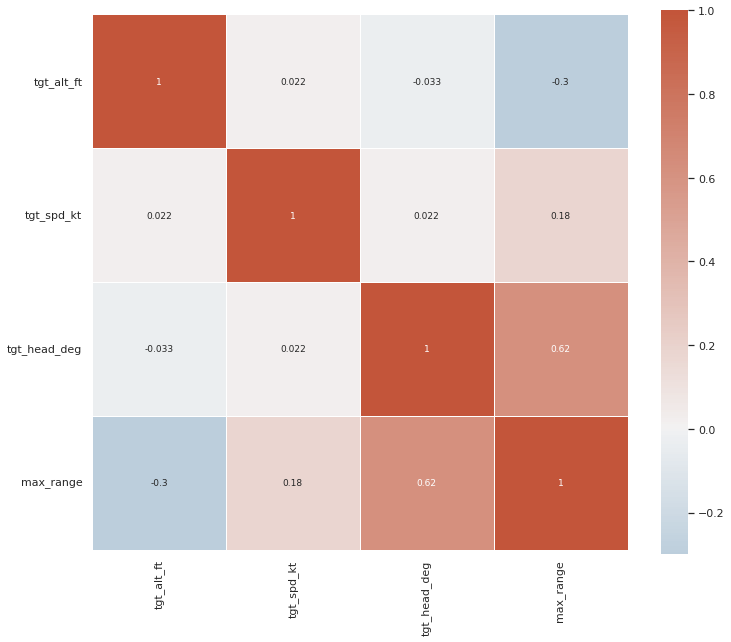

In [23]:
plt.rcParams.update({'font.size': 9})

corr_pearson = df_0_180.corr(method='pearson').round(4)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_pearson, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr_pearson, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 1.0}, annot=True);
#g = sns.heatmap(corr_pearson, cmap=cmap, vmax=1.0, vmin =-1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 1.0}, annot=True);
#g = sns.heatmap(corr_pearson, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.xticks(rotation=90)
plt.yticks(rotation=0) 

plt.show()
#plt.savefig ('figures/corr_eps.eps', format ='eps')
# plt.savefig ('figures/corr_png400.png', format ='png', dpi=400)

### Outliers

In [24]:
df_0_180[df_0_180['max_range'] == -1]

,tgt_alt_ft,tgt_spd_kt,tgt_head_deg,max_range


In [25]:
from numpy import percentile

outliers_cols = df_0_180.columns
outliers = {}
outliers_removed = {}
for idx, col in enumerate(outliers_cols):
    # calculate interquartile range
    data = df_0_180[col]
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    print(f'Variable ({idx+1}): {col}\nPercentiles: 25th = {q25:.3f}, 75th = { q75:.3f}, IQR = {iqr:.3f}')
    # calculate the outlier cutoff
    k = 1.5
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers[col] = [x for x in data if x < lower or x > upper]
    print(f'Identified outliers: {len(outliers[col])}')
    # remove outliers
    outliers_removed[col] = [x for x in data if x >= lower and x <= upper]
    print(f'Non-outlier observations: {len(outliers_removed[col])}\n')

Variable (1): tgt_alt_ft
Percentiles: 25th = 7837.053, 75th = 32610.411, IQR = 24773.359
Identified outliers: 0
Non-outlier observations: 24780

Variable (2): tgt_spd_kt
Percentiles: 25th = 361.107, 75th = 685.249, IQR = 324.143
Identified outliers: 0
Non-outlier observations: 24780

Variable (3): tgt_head_deg
Percentiles: 25th = 146.548, 75th = 168.848, IQR = 22.300
Identified outliers: 3709
Non-outlier observations: 21071

Variable (4): max_range
Percentiles: 25th = 13.672, 75th = 28.047, IQR = 14.375
Identified outliers: 1597
Non-outlier observations: 23183

